# FX vol trading strategy - implementation

In [53]:
# Import libraries
import pandas as pd
import numpy as np
from data_cleaning.import_data import import_data
from utils.garch import get_rolling_vol_forecasts
from utils.plots import plot_trades
from utils.trading_strategy import gen_trading_signals
from arch import arch_model

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Pick FX pair and set up model

In [65]:
# Load return data
pair = 'USDBRL'
df = import_data(fx_pair=pair)
df.dropna(inplace=True)
returns = df['log_ret'] * 100


In [66]:
df.head(21)

,v1m,v3m,v1y,px_last,px_bid,px_ask,log_ret,rolling_21d_realized_stdev,bid_ask_spread_pips
Dates,,,,,,,,,
2003-10-01,12.65,13.90,17.00,2.8950,2.8945,2.8955,-0.001726,9.143713,10.0
2003-10-02,12.65,13.90,17.00,2.8875,2.8865,2.8875,-0.002594,9.288762,10.0
2003-10-03,12.65,13.90,17.00,2.8860,2.8850,2.8870,-0.000520,8.416267,20.0
2003-10-06,12.65,13.90,17.00,2.8625,2.8610,2.8640,-0.008176,8.554776,30.0
2003-10-07,12.65,13.90,17.00,2.8590,2.8580,2.8600,-0.001223,7.537289,20.0
2003-10-08,12.65,13.90,17.00,2.8450,2.8450,2.8450,-0.004909,7.174508,0.0
2003-10-09,12.65,13.90,17.00,2.8315,2.8300,2.8330,-0.004756,6.740736,30.0
2003-10-10,12.65,13.90,17.00,2.8310,2.8300,2.8320,-0.000177,6.168041,20.0
2003-10-13,12.65,13.90,17.00,2.8350,2.8340,2.8360,0.001412,5.975807,20.0


<AxesSubplot:xlabel='Dates'>

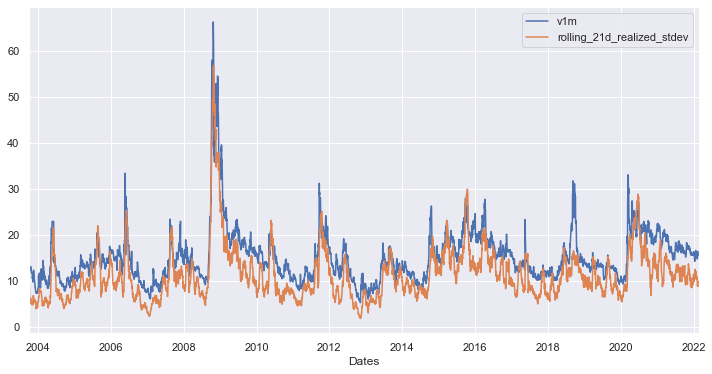

In [62]:
df[['v1m','rolling_21d_realized_stdev']].plot(figsize=(12,6))

## Forecast volatility

In [67]:
# ARCH model
model = arch_model(returns, mean='AR', vol='GARCH', p=2,q=1, dist = 'Studentst')

# Conditional volatility forecasting
vol_forecasts = get_rolling_vol_forecasts(return_series=returns, 
                                            model=model, 
                                            horizon=21,
                                            fitting_end_date="2021-01-01",
                                            )
vol_forecasts = vol_forecasts.multiply(np.sqrt(252))

df = df.merge(vol_forecasts['h.21'], left_index=True, right_index=True)
df.rename(columns={'h.21':'cond_vol_forecast'},inplace=True)
df['cond_forecast_to_implied'] = df['cond_vol_forecast'] / df['v1m']
df

Number of forecasts: 298
..........................................................................................................................................................................................................................................................................................................

,v1m,v3m,v1y,px_last,px_bid,px_ask,log_ret,rolling_21d_realized_stdev,bid_ask_spread_pips,cond_vol_forecast,cond_forecast_to_implied
2021-01-01,21.290,19.388,17.515,5.1985,5.1966,5.2003,0.000000,10.608245,37.0,13.676756,0.642403
2021-01-04,21.630,19.620,17.413,5.2717,5.2710,5.2725,0.013983,11.250801,15.0,15.759419,0.728591
2021-01-05,22.522,19.908,17.700,5.2766,5.2761,5.2770,0.000929,10.985761,9.0,14.530992,0.645191
2021-01-06,21.730,19.390,17.445,5.3006,5.2997,5.3015,0.004538,11.141050,18.0,13.757272,0.633100
2021-01-07,21.823,19.895,17.500,5.4009,5.4004,5.4015,0.018746,11.840930,11.0,18.266415,0.837026
...,...,...,...,...,...,...,...,...,...,...,...
2022-02-16,15.680,16.052,17.382,5.1293,5.1289,5.1297,-0.007749,9.961798,8.0,12.018819,0.766506
2022-02-17,16.292,16.145,17.470,5.1697,5.1693,5.1701,0.007845,8.880165,8.0,12.136187,0.744917
2022-02-18,15.585,16.090,17.515,5.1388,5.1385,5.1391,-0.005995,9.209715,6.0,11.832145,0.759201
2022-02-21,15.955,16.188,17.515,5.1064,5.1060,5.1068,-0.006325,9.489284,8.0,11.633602,0.729151


## Generate trading signals

In [68]:
threshold_up = 1.1
threshold_down = 0.9

gen_trading_signals(df,thres_up=threshold_up,thres_down=threshold_down)
df.tail(10)

,v1m,v3m,v1y,px_last,px_bid,px_ask,log_ret,rolling_21d_realized_stdev,bid_ask_spread_pips,cond_vol_forecast,cond_forecast_to_implied,direction,direction_flag
2022-02-09,14.905,15.815,17.465,5.2347,5.2343,5.2350,-0.004555,9.522999,7.0,13.300773,0.892370,0,nan
2022-02-10,14.855,15.667,17.375,5.2497,5.2491,5.2502,0.002861,9.021069,11.0,12.537475,0.843990,0,nan
2022-02-11,16.075,16.202,17.590,5.2490,5.2484,5.2495,-0.000133,8.913476,11.0,11.715653,0.728812,0,nan
2022-02-14,16.472,16.658,17.750,5.2189,5.2186,5.2193,-0.005751,9.335899,7.0,11.414235,0.692948,0,nan
2022-02-15,16.125,16.430,17.490,5.1692,5.1687,5.1696,-0.009569,9.990822,9.0,11.950749,0.741132,0,nan
2022-02-16,15.680,16.052,17.382,5.1293,5.1289,5.1297,-0.007749,9.961798,8.0,12.018819,0.766506,0,nan
2022-02-17,16.292,16.145,17.470,5.1697,5.1693,5.1701,0.007845,8.880165,8.0,12.136187,0.744917,0,nan
2022-02-18,15.585,16.090,17.515,5.1388,5.1385,5.1391,-0.005995,9.209715,6.0,11.832145,0.759201,0,nan
2022-02-21,15.955,16.188,17.515,5.1064,5.1060,5.1068,-0.006325,9.489284,8.0,11.633602,0.729151,0,nan
2022-02-22,15.900,16.160,17.487,5.1064,5.1060,5.1068,0.000000,8.944912,8.0,10.900086,0.685540,-1,Sell straddle


## How does the trades look?

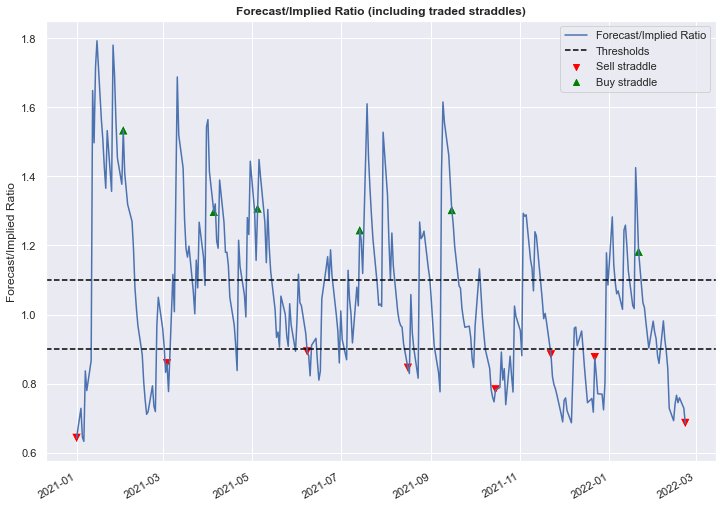

In [69]:
plot_trades(df,thres_up=threshold_up,thres_down=threshold_down)

In [70]:
df

,v1m,v3m,v1y,px_last,px_bid,px_ask,log_ret,rolling_21d_realized_stdev,bid_ask_spread_pips,cond_vol_forecast,cond_forecast_to_implied,direction,direction_flag
2021-01-01,21.290,19.388,17.515,5.1985,5.1966,5.2003,0.000000,10.608245,37.0,13.676756,0.642403,-1,Sell straddle
2021-01-04,21.630,19.620,17.413,5.2717,5.2710,5.2725,0.013983,11.250801,15.0,15.759419,0.728591,0,nan
2021-01-05,22.522,19.908,17.700,5.2766,5.2761,5.2770,0.000929,10.985761,9.0,14.530992,0.645191,0,nan
2021-01-06,21.730,19.390,17.445,5.3006,5.2997,5.3015,0.004538,11.141050,18.0,13.757272,0.633100,0,nan
2021-01-07,21.823,19.895,17.500,5.4009,5.4004,5.4015,0.018746,11.840930,11.0,18.266415,0.837026,0,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-16,15.680,16.052,17.382,5.1293,5.1289,5.1297,-0.007749,9.961798,8.0,12.018819,0.766506,0,nan
2022-02-17,16.292,16.145,17.470,5.1697,5.1693,5.1701,0.007845,8.880165,8.0,12.136187,0.744917,0,nan
2022-02-18,15.585,16.090,17.515,5.1388,5.1385,5.1391,-0.005995,9.209715,6.0,11.832145,0.759201,0,nan
2022-02-21,15.955,16.188,17.515,5.1064,5.1060,5.1068,-0.006325,9.489284,8.0,11.633602,0.729151,0,nan


In [71]:
df['returns'] = np.where(
    df['direction'] != 0, 
    (df['direction'] * df['rolling_21d_realized_stdev'].shift(-21)-df['direction']*df['v1m'] )/df['v1m'], 
    0)  

<AxesSubplot:>

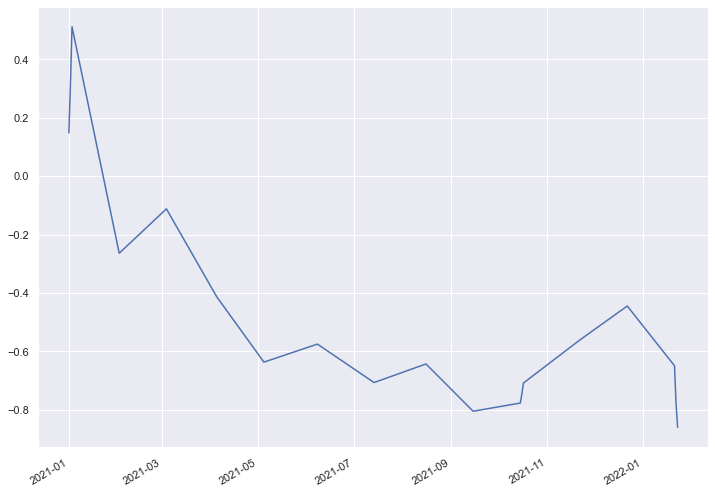

In [77]:
df_performance = df.loc[df['direction']!=0][['v1m','direction','returns']]
df.loc[pd.Timestamp('2020-08-09')] = 0
df = df.sort_index().asfreq('D', method='pad')
df_performance['normalized_pnl'] = np.cumprod(1 + df_performance['returns'].values) - 1
df_performance['normalized_pnl'].plot()


In [79]:
df

,v1m,v3m,v1y,px_last,px_bid,px_ask,log_ret,rolling_21d_realized_stdev,bid_ask_spread_pips,cond_vol_forecast,cond_forecast_to_implied,direction,direction_flag,returns
2020-08-09,0.000,0.000,0.000,0.0000,0.0000,0.0000,0.000000,0.000000,0.0,0.000000,0.000000,0,0,0.0
2020-08-10,0.000,0.000,0.000,0.0000,0.0000,0.0000,0.000000,0.000000,0.0,0.000000,0.000000,0,0,0.0
2020-08-11,0.000,0.000,0.000,0.0000,0.0000,0.0000,0.000000,0.000000,0.0,0.000000,0.000000,0,0,0.0
2020-08-12,0.000,0.000,0.000,0.0000,0.0000,0.0000,0.000000,0.000000,0.0,0.000000,0.000000,0,0,0.0
2020-08-13,0.000,0.000,0.000,0.0000,0.0000,0.0000,0.000000,0.000000,0.0,0.000000,0.000000,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-18,15.585,16.090,17.515,5.1388,5.1385,5.1391,-0.005995,9.209715,6.0,11.832145,0.759201,0,nan,0.0
2022-02-19,15.585,16.090,17.515,5.1388,5.1385,5.1391,-0.005995,9.209715,6.0,11.832145,0.759201,0,nan,0.0
2022-02-20,15.585,16.090,17.515,5.1388,5.1385,5.1391,-0.005995,9.209715,6.0,11.832145,0.759201,0,nan,0.0
2022-02-21,15.955,16.188,17.515,5.1064,5.1060,5.1068,-0.006325,9.489284,8.0,11.633602,0.729151,0,nan,0.0


In [78]:
df_performance

,v1m,direction,returns,normalized_pnl
2021-01-01,21.290,-1,0.147346,0.147346
2021-01-02,21.290,-1,0.147346,0.316404
2021-01-03,21.290,-1,0.147346,0.510371
2021-02-02,19.485,1,-0.512738,-0.264054
2021-03-04,19.575,-1,0.206229,-0.112281
2021-04-05,19.210,1,-0.338737,-0.412985
2021-05-05,17.347,1,-0.380548,-0.636372
2021-06-08,14.970,-1,0.169534,-0.574724
2021-07-14,17.050,1,-0.309189,-0.706215
2021-08-16,17.045,-1,0.216277,-0.642676
